# Overview
ClinVar is a public resource containing annotations about human genetic variants. These variants are (usually manually) classified by clinical laboratories on a categorical spectrum ranging from benign, likely benign, uncertain significance, likely pathogenic, and pathogenic. Variants that have conflicting classifications (from laboratory to laboratory) can cause confusion when clinicians or researchers try to interpret whether the variant has an impact on the disease of a given patient.

Conflicting classifications are when any *two* of the following three categories are present for *one* variant

Likely Benign or Benign

VUS (uncertain significance) 

Likely Pathogenic or Pathogenic

Otherwise the classification is labelled as in agreement.


# Objective 
To predict whether a ClinVar variant will have conflicting classifications. This is presented here as a binary classification problem, where each record in the dataset is a genetic variant.

Conflicting classification has been assigned to the CLASS column of the data. It is a binary representation of whether or not a variant has conflicting classifications, where 0 represents consistent classifications and 1 represents conflicting classifications.

The purpose of this notebook is to find patterns, trends, and relationships between various features of the classifications and search for best machine learning algorithms to predict on new data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
df= pd.read_csv('clinvar_conflicting.csv', low_memory=False)
df.head()

,CHROM,POS,REF,ALT,AF_ESP,AF_EXAC,AF_TGP,CLNDISDB,CLNDISDBINCL,CLNDN,...,SIFT,PolyPhen,MOTIF_NAME,MOTIF_POS,HIGH_INF_POS,MOTIF_SCORE_CHANGE,LoFtool,CADD_PHRED,CADD_RAW,BLOSUM62
0,1,955563,G,C,0.0000,0.00000,0.0000,"MedGen:C3808739,OMIM:615120|MedGen:CN169374",NaN,"Myasthenic_syndrome,_congenital,_8|not_specified",...,NaN,NaN,NaN,NaN,NaN,NaN,0.421,11.390,1.133255,-2.0
1,1,955597,G,T,0.0000,0.42418,0.2826,MedGen:CN169374,NaN,not_specified,...,NaN,NaN,NaN,NaN,NaN,NaN,0.421,8.150,0.599088,NaN
2,1,955619,G,C,0.0000,0.03475,0.0088,"MedGen:C3808739,OMIM:615120|MedGen:CN169374",NaN,"Myasthenic_syndrome,_congenital,_8|not_specified",...,NaN,NaN,NaN,NaN,NaN,NaN,0.421,3.288,0.069819,1.0
3,1,957640,C,T,0.0318,0.02016,0.0328,"MedGen:C3808739,OMIM:615120|MedGen:CN169374",NaN,"Myasthenic_syndrome,_congenital,_8|not_specified",...,NaN,NaN,NaN,NaN,NaN,NaN,0.421,12.560,1.356499,NaN
4,1,976059,C,T,0.0000,0.00022,0.0010,MedGen:CN169374,NaN,not_specified,...,NaN,NaN,NaN,NaN,NaN,NaN,0.421,17.740,2.234711,NaN


# Exploratory Data Analysis

In [3]:
print('Number of features:',df.columns.size)
print('Number of observations:', df.index.size)

Number of features: 46
Number of observations: 65188


The wrangled dataframe contains 46 variables and 65188 observations. This means that there are 45 feature variables and 1 target variable (the classification binary value). 

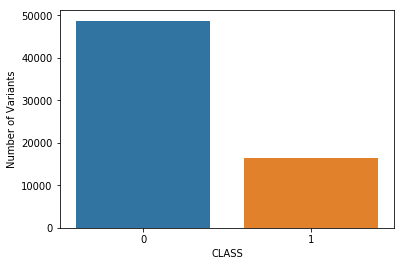

In [4]:
# visualize distribution of binary value CLASS
cnt= sns.countplot(x='CLASS', data=df)
cnt.set(xlabel='CLASS', ylabel= 'Number of Variants')
plt.savefig('split.png')
plt.show()

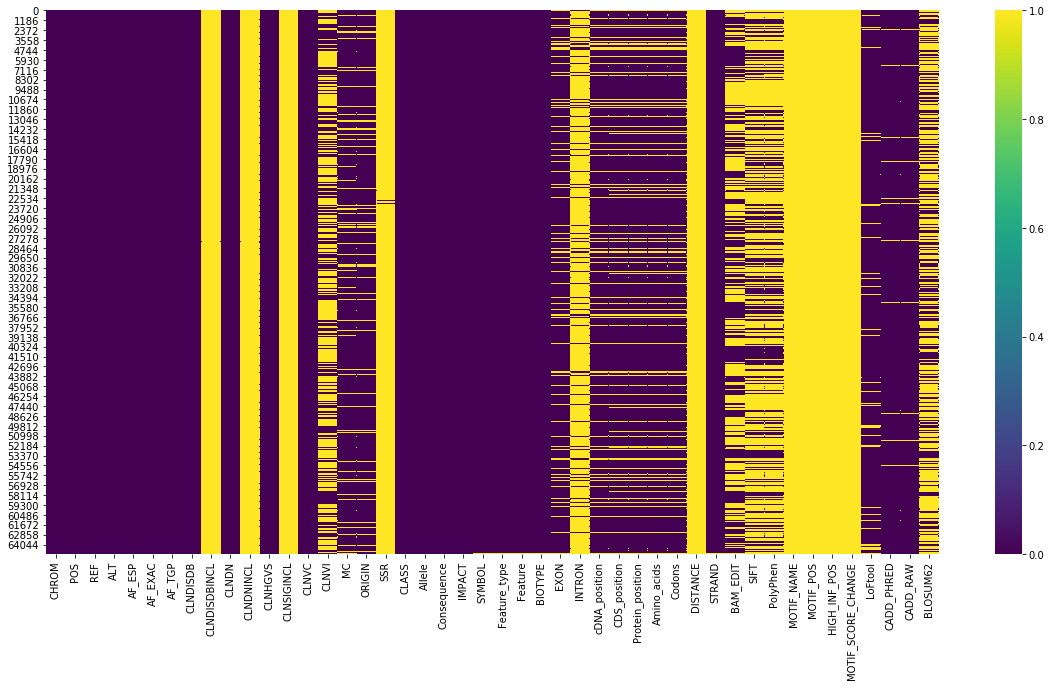

In [5]:
# visually examine null values
fig = plt.figure(figsize = (20,10))
sns.heatmap(df.isnull(), cmap = 'viridis', cbar = True)
plt.savefig('null.png')
plt.show()

Above are two plots that visualize the data. The first shows a count plof of the clinical lab classifications. From this I can see that there are 3 times as many clinical agreements than there are conflicts. This observation suggests that the anomalies lie within the conflicting cases. However, valuable insight can be drawn from both CLASS cases that shed light solely on the conflicting case so the analysis will proceed to study both cases in tandum. 

The second plot highlights the amount of null values that each feature contains. These features will provide no value to the analysis of the data, and will be dropped.

## Data cleaning and processing

The data cleaning and processing will involve 2 steps 

1. Filter out of the dataframe all features with less than 50000 non-null entries
2. Drop features with > (10% of number of observations) unique values

The ultimate goal of this notebook is to discover patterns and relationships between features and classifications. I will therefore drop those features which contain several null values or contain several unique values (which would inhibit pattern findings).

In [6]:
# define function to filter a dataframe's columns based on how many non-null objects they have

def filter_df(data,num_of_entries):    
    list= []
    for x in data.columns:
        if data[x].count() >= num_of_entries:
            list.append(x)
    return data[list]

In [7]:
fildf= filter_df(df,50000)
fildf=fildf.dropna()

# establish a list of cutdowns to be made on dataframe fildf where each feature has < 1000 unique elements
cutdowns = []
for i in fildf.columns.values:
    if fildf[i].nunique() < 4000:
        cutdowns.append(i)
df2=fildf[cutdowns]

In [8]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44572 entries, 0 to 65171
Data columns (total 22 columns):
CHROM           44572 non-null object
REF             44572 non-null object
ALT             44572 non-null object
AF_ESP          44572 non-null float64
AF_EXAC         44572 non-null float64
AF_TGP          44572 non-null float64
CLNVC           44572 non-null object
MC              44572 non-null object
ORIGIN          44572 non-null float64
CLASS           44572 non-null int64
Allele          44572 non-null object
Consequence     44572 non-null object
IMPACT          44572 non-null object
SYMBOL          44572 non-null object
Feature_type    44572 non-null object
Feature         44572 non-null object
BIOTYPE         44572 non-null object
EXON            44572 non-null object
Amino_acids     44572 non-null object
Codons          44572 non-null object
STRAND          44572 non-null float64
LoFtool         44572 non-null float64
dtypes: float64(6), int64(1), object(15)
memory us

The result of our data cleaning and processing is shown in the info call. I filtered the original dataframe by features with less than 4000 unique values and greater than 50000 non-null entries. The final product of this process is a full dataframe with 21 feature variables and 1 target variable (CLASS), each with 44572 non-null entries. This will make for an abundance of data to work with to discover patterns and relationships. 

## Data Visualization 

Questions: 

1. Which feature variables have a visual correlation to the target variable CLASS?
2. How do the values of feature variables relate to the target variable in terms of counts and percentages?
3. Are there any more feature variables that should be cut from the current dataframe in preperation of applying ML algorithms?

I will move onto visually inspecting the feature variables as they relate to the target variable to see if I can determine outstanding relationships. To do this I will first need to crosstabulate the data i.e. how many times each value of the features occurs in which classification (0,1). I will take the top *x* results and visualize their cross-tabulation with the classifications by constructing three heatmaps as described below:

1. A number of occurrences count cross-tabulation that shows how many times a specific value occurred in which classification
2. A percentage-of-total cross-tabulation, which will show the *percentage* of the *total number* of values each value has in the cross tabulation
3. A split percentage cross-tabulation, which will show the percentage breakdown of classification between values (i.e. 40% classified as 1 and 60% classified as 0)

In [9]:
#general cross-tabulation function -> can tabulate any two features
def ctab(df,variable1, x, variable2, y):
    # a and b are dataframes containing top x,y most occuring values (sorted high->low) in the variables variable1,variable2
    a=df.groupby(variable1).size().to_frame('cnt').sort_values('cnt', ascending= False).iloc[:x]
    b=df.groupby(variable2).size().to_frame('cnt').sort_values('cnt', ascending= False).iloc[:y]
    
    # c will create a new dataframe filtered by intersecting a,b variable values
    
    c= df[df[variable1].isin(a.index.values) & df[variable2].isin(b.index.values)]
    
    # .isin accepts a list as an argument and will filter based upon what values are in that list
    # much like SQL IN clause
    # to get dataframes a and b into appropriate list forms we first call .index, which accessess the indices list of the 
    # dataframe variables values and then .values turns into a numpy array
    
    # crosstabulate the variables of interest
    return pd.crosstab(c[variable1],c[variable2])

In [10]:
# mapping function explictely constructed to look at feature variables vs target variable CLASS
def map(variable2, y, df=df2, variable1='CLASS',x=2):
    # incorporate ctab function
    crosstab= ctab(df, variable1, x, variable2, y)
    
    # construct and format subplots
    fig, ax= plt.subplots(2,2, figsize= (10,5))
    fig.tight_layout()
    plt.subplots_adjust(wspace=.3,hspace=.5)
    # hide axes of (1,1) subplot
    ax[-1, -1].axis('off')
    # standard countplot of crosstabulation
    sns.heatmap(crosstab, cmap='Blues', linewidth=.05, linecolor= 'black', ax= ax[0,0])
    ax[0,0].set_title('1. Number of Occurrences')

    # frequency of occurances compared to total number of entries per classification (0,1)
    zero_tot_div= df2[df2.CLASS==0][crosstab.columns.name].size
    one_tot_div= df2[df2.CLASS==1][crosstab.columns.name].size
    tot_div= crosstab.div([zero_tot_div, one_tot_div], axis=0)
    sns.heatmap(tot_div, cmap='Reds', linewidth=.05, linecolor= 'black', ax= ax[0,1])
    ax[0,1].set_title('2. Percentage of Total')

    # perentages of feature that split into classification 0 or 1
    divisor= np.sum(crosstab.values, axis=0)
    split_per= crosstab.div(divisor)
    sns.heatmap(split_per, cmap='Greens', linewidth=.05, linecolor= 'black', ax= ax[1,0])
    ax[1,0].set_title('3. Split Percentage')
    

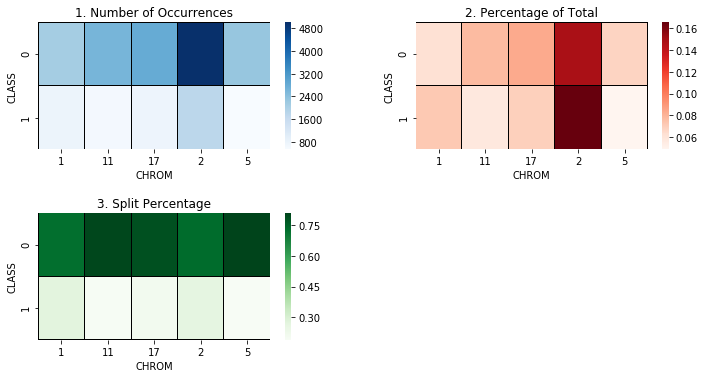

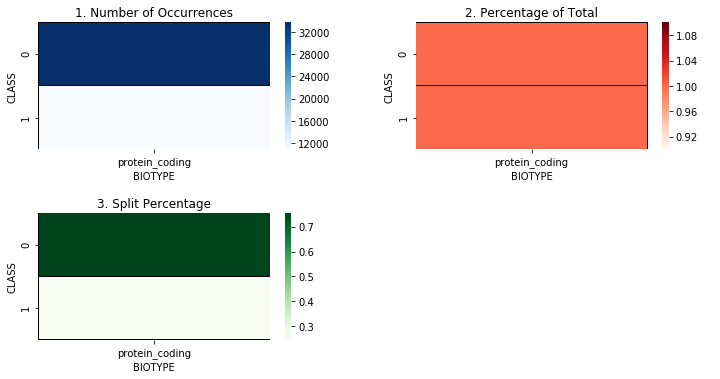

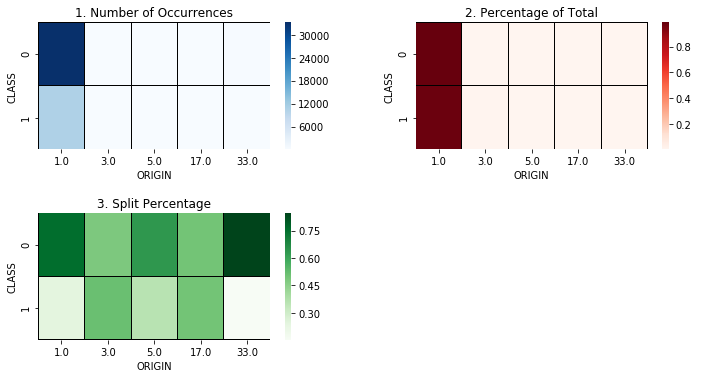

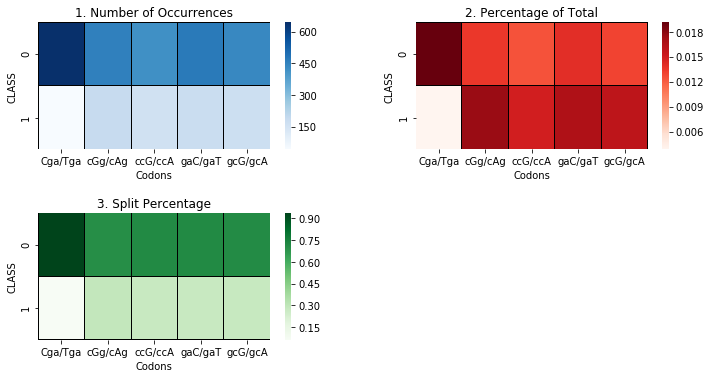

In [11]:
# take every feature in cleaned dataframe and visualize corresponding 3 heatmaps 
# this will inform our decision to drop any more features
for i in ['CHROM','BIOTYPE','ORIGIN','Codons'] :
  #  if i=='CLASS':
   #     continue
   # else:
        map(i,5) 
        plt.savefig(i+'.png')
# majority of feature heatmaps suppressed for computation purposes- the 4 feature variables heatmapped by this code are
# representative of the rest

In [12]:
df3= df2.drop(columns=['BIOTYPE','Feature_type','ORIGIN','CLNVC','Feature','EXON', 'Amino_acids','Codons','LoFtool'], axis=1)\
.reset_index()
df3= df3.drop(columns='index')
df3.head()

,CHROM,REF,ALT,AF_ESP,AF_EXAC,AF_TGP,MC,CLASS,Allele,Consequence,IMPACT,SYMBOL,STRAND
0,1,G,C,0.0000,0.00000,0.0000,SO:0001583|missense_variant,0,C,missense_variant,MODERATE,AGRN,1.0
1,1,G,T,0.0000,0.42418,0.2826,SO:0001819|synonymous_variant,0,T,synonymous_variant,LOW,AGRN,1.0
2,1,G,C,0.0000,0.03475,0.0088,SO:0001583|missense_variant,1,C,missense_variant,MODERATE,AGRN,1.0
3,1,C,T,0.0318,0.02016,0.0328,SO:0001819|synonymous_variant,0,T,synonymous_variant,LOW,AGRN,1.0
4,1,C,T,0.0000,0.00022,0.0010,SO:0001819|synonymous_variant,1,T,synonymous_variant,LOW,AGRN,1.0


The result of the visualization revealed an interesting insight. Although the features 'BIOTYPE' and 'Feature_type' made it through the data cleaning and processing stage, the visualization highlighted the fact that they only have 1 unique value each. Including these features in the machine learning model will be redundent and offer no substantial information. Therefore we will drop them. Furthermore, the feature variables 'ORIGIN' and 'CLNVC' display a similar phenonmneon. Although they both have more than one unique value, a bulk of total percentage lies in only one value (resemebles the problem in the previous 2 variables). On the opposite side of the spectrum, the feature variables 'Feature','EXON', 'Amino_acids','Codons', and 'LoFtool' have far too many unique values and could lead a ML model to overfit the data (or have a long computation time). Therefore we cut all of the feature variables. The remaining 12 feature variables look promising on a visual level in terms of target variable correlation. The next step of my analysis will be a feature chi-square selection to determine correlations between the feature variables and the target variable. For the machine learning model to be truly optimized, there must be some correlation between the model's feature variables and the target variable.

## Pearson Chi-Squared Test

The Chi-Squared test is a statistical hypothesis test observed frequencies vs expected frequencies under the following null hypothesis.

Null Hypothesis (H0)- the observed frequencies match expected frequencies i.e. the two variables are *independent*

Alternative Hypothesis- the observed frequencies do not match the expected frequencies i.e. the two variables have some dependency

In [13]:
from scipy.stats import chi2, chi2_contingency

In [14]:
# Construct function that will run chi-square test for all feature variables to test for categorical dependence significance.
for i in df3.columns:
    prob=.99
    if i=='CLASS':
        continue
    else: 
        print(i +' feature is:')
        table= ctab(df3,'CLASS',2,i,df3[i].size)
        stat, p, dof, expected = chi2_contingency(table)
        critical= chi2.ppf(prob,dof)
        print('P-value:',p)
        if abs(stat) >= critical:
            print('Dependent- reject H0 \n')
        else:
            print('Independent (fail to reject H0) \n')

CHROM feature is:
P-value: 9.858021132759068e-49
Dependent- reject H0 

REF feature is:
P-value: 0.008959911563326062
Dependent- reject H0 

ALT feature is:
P-value: 0.07665218907151529
Independent (fail to reject H0) 

AF_ESP feature is:
P-value: 5.395652117800568e-113
Dependent- reject H0 

AF_EXAC feature is:
P-value: 3.2598428254959263e-99
Dependent- reject H0 

AF_TGP feature is:
P-value: 2.1876108405572567e-200
Dependent- reject H0 

MC feature is:
P-value: 8.177537721972858e-91
Dependent- reject H0 

Allele feature is:
P-value: 3.8917089655568735e-09
Dependent- reject H0 

Consequence feature is:
P-value: 2.9253751555872266e-104
Dependent- reject H0 

IMPACT feature is:
P-value: 8.964615863520214e-112
Dependent- reject H0 

SYMBOL feature is:
P-value: 3.0357508501483067e-267
Dependent- reject H0 

STRAND feature is:
P-value: 1.313143276839513e-20
Dependent- reject H0 



The result of my Chi-squared test determined only one variable to be independent of the binary CLASS variable- ALT. The ALT feature failed the Chi-Squared significance test and will therefore be dropped from the dataframe in preperation to apply machine learning algorithms. This means that there are 11 remaining feature variables to predict the target CLASS variable. Before I begin to apply ML algorithms, however, I will preprocess the categorical feature variables through feature engineering to ensure optimum model performance

## Feature Engineering